In [1]:
from torchvision.datasets import MNIST
import numpy as np

In [2]:
MNIST_train = MNIST('./', download=True, train=True)
MNIST_test = MNIST('./', download=True, train=False)

In [3]:
test_images = MNIST_test.test_data

C:\Users\lizzka239\anaconda3\envs\chemvae\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

C:\Users\lizzka239\anaconda3\envs\chemvae\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\lizzka239\anaconda3\envs\chemvae\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\lizzka239\anaconda3\envs\chemvae\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


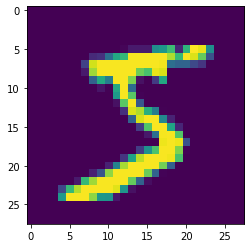

tensor(5)


In [5]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [6]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [7]:
X_train.shape

torch.Size([60000, 1, 28, 28])

# Network architecture

In [8]:
import torch.nn as nn
import torch.optim as optim

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=1)
        self.act1  = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=0)
        self.act2  = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = nn.Linear(6 * 6 * 10, 100)
        self.act3  = nn.ReLU()
        
        self.fc2   = nn.Linear(100, 10)
        
        self.act4 = nn.Softmax(dim=1)
    
    def forward(self, x, last=True):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        
        x = self.fc2(x)
        if last:
            x = self.act4(x)
        
        return x

# Loss and metrics

In [33]:
net = Net()

In [34]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1.0e-3)

# Training

In [35]:
batch_size = 5000

test_accuracy = []
test_loss = []

for epoch in range(40):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = net.forward(X_test)
    test_loss.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy.append(accuracy)
    
    print(accuracy)

tensor(0.6939)
tensor(0.7434)
tensor(0.8020)
tensor(0.8520)
tensor(0.8614)
tensor(0.8663)
tensor(0.8716)
tensor(0.8750)
tensor(0.8760)
tensor(0.8774)
tensor(0.8803)
tensor(0.8807)
tensor(0.8821)
tensor(0.8846)
tensor(0.8843)
tensor(0.8858)
tensor(0.8828)
tensor(0.8861)
tensor(0.8863)
tensor(0.8870)
tensor(0.8870)
tensor(0.8863)
tensor(0.8863)
tensor(0.8878)
tensor(0.8881)
tensor(0.8882)
tensor(0.9619)
tensor(0.9756)
tensor(0.9783)
tensor(0.9804)
tensor(0.9821)
tensor(0.9831)
tensor(0.9821)
tensor(0.9837)
tensor(0.9849)
tensor(0.9854)
tensor(0.9848)
tensor(0.9860)
tensor(0.9852)
tensor(0.9863)


# Confusion Matrix

In [36]:
def confusion_matrix(actual, pred, class_names):
    NUM_CLASSES = len(class_names)
    cm = [[0 for j in range(NUM_CLASSES)] for i in range(NUM_CLASSES)]
    most_similar = [(-1, 0.0) for i in range(NUM_CLASSES * NUM_CLASSES)]

    for (i, labels_prob) in enumerate(pred):
        label = np.argmax(labels_prob.detach().numpy())
        cm[actual[i]][label] += 1

        if labels_prob[label] > most_similar[actual[i].item() * NUM_CLASSES + label][1]:
            most_similar[actual[i].item() * NUM_CLASSES + label] = (i, labels_prob[label])
    
    print(np.array(cm).reshape(-1, NUM_CLASSES))
    
    blank_image = [[255 for j in range(28)] for i in range(28)]
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=0.8, hspace=0.1)
    for i in range(NUM_CLASSES * NUM_CLASSES):
        plt.subplot(10, 10, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if most_similar[i][0] == -1:
            plt.imshow(blank_image, cmap=plt.cm.binary)
            continue
        plt.imshow(test_images[most_similar[i][0]], cmap=plt.cm.binary)
        plt.xlabel(class_names[i % NUM_CLASSES])
    plt.show()

[[ 973    0    0    0    0    1    2    1    3    0]
 [   0 1127    2    0    0    2    1    0    3    0]
 [   4    1 1015    4    0    0    0    4    4    0]
 [   0    0    1 1004    0    1    0    1    2    1]
 [   0    0    4    0  962    0    5    1    3    7]
 [   2    0    0    7    0  879    4    0    0    0]
 [   4    1    0    0    1    4  947    0    1    0]
 [   1    1    7    1    0    0    0 1013    2    3]
 [   7    0    3    1    1    1    0    4  953    4]
 [   2    1    0    3    6    0    1    5    1  990]]


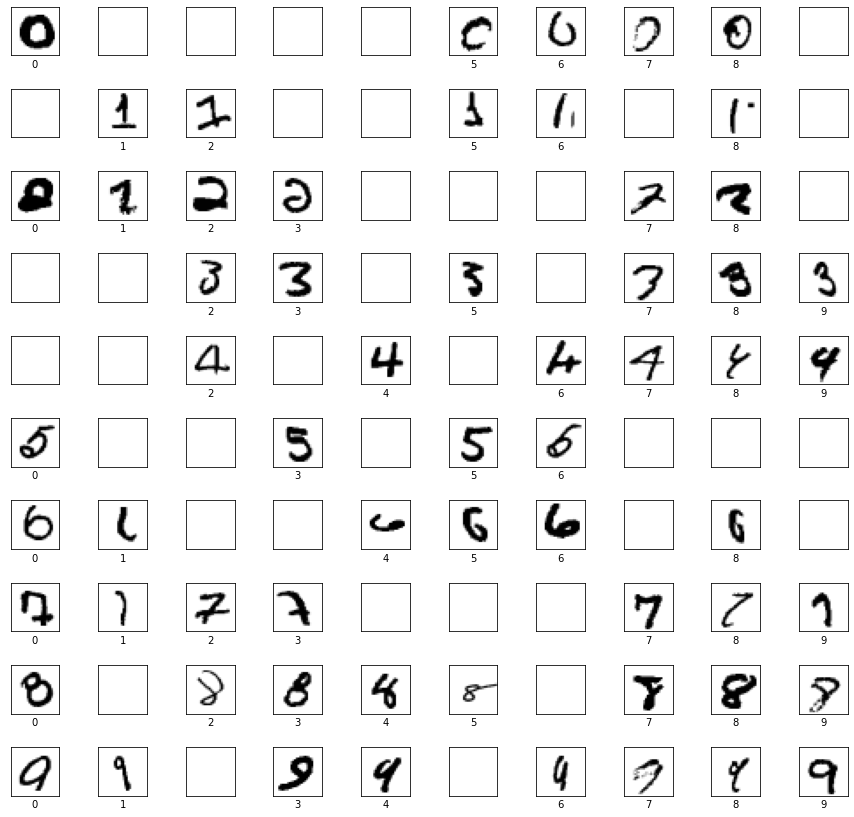

In [37]:
test_preds = net.forward(X_test, last=False)
confusion_matrix(y_test, test_preds, [i for i in range(10)])

# FashionMnist

In [38]:
from torchvision.datasets import FashionMNIST
MNIST_train = FashionMNIST('./', download=True, train=True)
MNIST_test = FashionMNIST('./', download=True, train=False)
test_images = MNIST_test.test_data
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw


Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw
Processing...
Done!


C:\Users\lizzka239\anaconda3\envs\chemvae\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\lizzka239\anaconda3\envs\chemvae\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\lizzka239\anaconda3\envs\chemvae\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\lizzka239\anaconda3\envs\chemvae\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


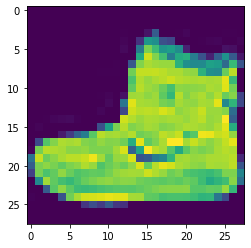



tensor(9)


In [39]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [40]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [41]:
net = Net()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1.0e-3)

In [42]:
batch_size = 5000

test_accuracy = []
test_loss = []

for epoch in range(40):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = net.forward(X_test)
    test_loss.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy.append(accuracy)
    
    print(accuracy)

tensor(0.5116)
tensor(0.6210)
tensor(0.6362)
tensor(0.6457)
tensor(0.6514)
tensor(0.6556)
tensor(0.6574)
tensor(0.6593)
tensor(0.7225)
tensor(0.7358)
tensor(0.7409)
tensor(0.7460)
tensor(0.7515)
tensor(0.7529)
tensor(0.7546)
tensor(0.7545)
tensor(0.7696)
tensor(0.7755)
tensor(0.7859)
tensor(0.7830)
tensor(0.7914)
tensor(0.7936)
tensor(0.7963)
tensor(0.8030)
tensor(0.8061)
tensor(0.8042)
tensor(0.8058)
tensor(0.8087)
tensor(0.8097)
tensor(0.8115)
tensor(0.8129)
tensor(0.8131)
tensor(0.8125)
tensor(0.8084)
tensor(0.8085)
tensor(0.8131)
tensor(0.8164)
tensor(0.8172)
tensor(0.8153)
tensor(0.8157)


[[846   2   0  41  13   0  81   0  17   0]
 [  3 965   0  23   4   1   2   0   2   0]
 [ 59   3   0  29 446   1 449   0  13   0]
 [ 12   3   0 923  33   0  27   0   2   0]
 [  2   2   0  44 911   0  40   0   1   0]
 [  0   0   0   0   0 963   0  24   1  12]
 [127   1   0  44 165   0 647   0  16   0]
 [  0   0   0   0   0  11   0 964   1  24]
 [  1   2   0   4   8   1   2   3 979   0]
 [  0   0   0   0   0   4   0  36   1 959]]


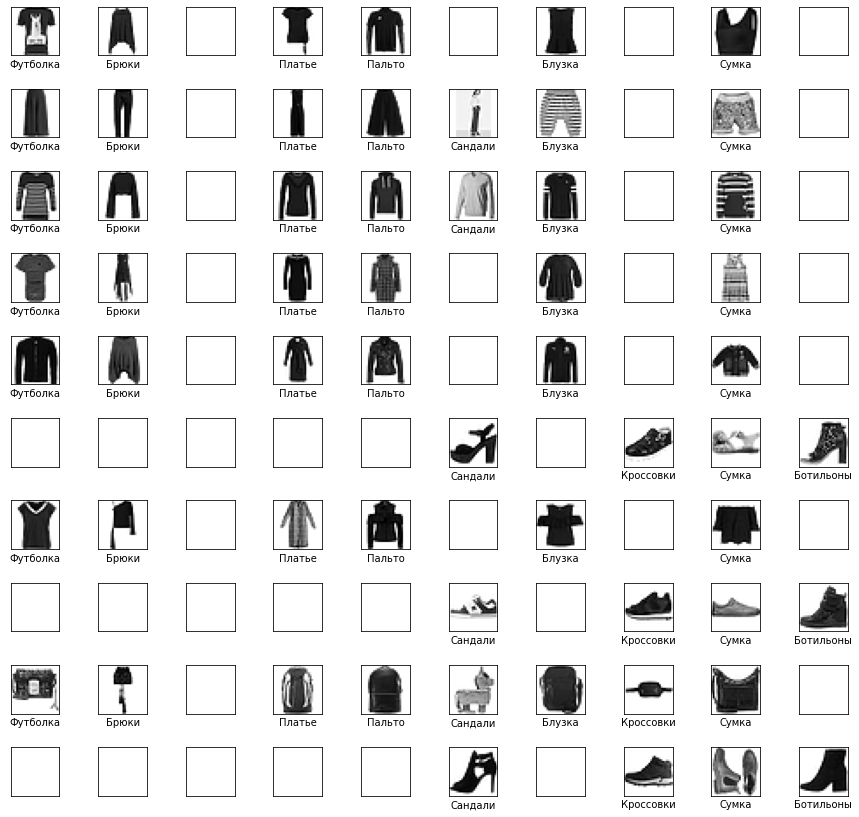

In [43]:
test_preds = net.forward(X_test, last=False)
confusion_matrix(y_test, test_preds, ['Футболка', 'Брюки', 'Свитер', 'Платье', 'Пальто', 'Сандали', 
                                      'Блузка', 'Кроссовки', 'Сумка', 'Ботильоны'])